# Required Libraries Installations

In [ ]:
pip install gradio # for button to upload pdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.1 MB/s e

In [ ]:
pip install pdfplumber bert-extractive-summarizer # for reading the pdf and summarizing the content


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 947.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.8 MB/s eta 0:00:00


In [ ]:
pip install rake_nltk # for keyword generation

In [ ]:
pip install transformers # for question generation

In [ ]:
pip install sentencepiece # for question generation tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00


# Reads the pdf and summarizes the content

In [ ]:
import re
import gradio as gr
import pdfplumber
from summarizer import Summarizer

# Extract text from the PDF using pdfplumber
def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

# Summarize the text using the bert-extractive-summarizer
def summarize_text(text):
    summarizer = Summarizer()
    summarized_text = summarizer(text)
    summarized_text = re.sub(r'[^a-zA-Z0-9.,\s]', '', summarized_text).strip()
    return summarized_text


# Getting the keywords using RAKE

In [ ]:
from rake_nltk import Rake

import nltk
from nltk.corpus import stopwords

# Download NLTK resources (if not already downloaded)
nltk.download("punkt")
nltk.download("stopwords")

# Initialize NLTK's stopwords
stop_words = set(stopwords.words("english"))

# Extract keywords from the summarized text using RAKE
def extract_keywords(summarized_text):
    r = Rake()

    # Extract keywords
    r.extract_keywords_from_text(summarized_text)

    # Get the ranked keywords
    ranked_keywords = r.get_ranked_phrases()

    # Process and clean the keywords
    cleaned_keywords = []
    for keyword in ranked_keywords:
        # Remove special characters and extra spaces using regular expression
        cleaned_keyword = re.sub(r'[^a-zA-Z0-9\s]', '', keyword).strip()
        cleaned_keywords.append(cleaned_keyword)

    # Get the top N cleaned keywords (e.g., top 10)
    top_keywords = cleaned_keywords[:10]

    return top_keywords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Question Generation using pretrained model

In [ ]:
import torch
from transformers import T5ForConditionalGeneration,T5Tokenizer

# connect your personal google drive to store dataset and trained model
from google.colab import drive
drive.mount('/content/gdrive')
trained_model_path = '/content/gdrive/My Drive/t5/model/'
trained_tokenizer = '/content/gdrive/My Drive/t5/tokenizer/'

model = T5ForConditionalGeneration.from_pretrained(trained_model_path)
tokenizer = T5Tokenizer.from_pretrained(trained_tokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)

def get_question(answers, context, max_length=64):
  questions = []
  for answer in answers:
    text = "context: "+context + " " + "answer: " + answer + " </s>"
    encoding = tokenizer.encode_plus(text,max_length =512, padding=True, return_tensors="pt")
    input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
    model.eval()
    beam_outputs = model.generate(
        input_ids=input_ids,attention_mask=attention_mask,
        max_length=72,
        early_stopping=True,
        num_beams=5,
        num_return_sequences=1

    )

    for beam_output in beam_outputs:
        sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        print (sent)
        questions.append(sent[10:])
  return questions

# context = "Machine learning is a subfield of artificial intelligence AI that focuses on the development of algorithms and statistical models that enable computers to improve their performance on a specific task through learning from data. Types of Learning Supervised Learning In this type, the model is trained on a labeled dataset, meaning it learns to map input data to specific output labels.  Unsupervised Learning Here, the model is given data without explicit labels, and its tasked with finding patterns, structures, or groupings in the data. Feature Extraction and Engineering Feature extraction involves selecting or transforming the relevant attributes features of the data to improve the models performance. Regularization techniques and proper model selection help mitigate these issues. Deployment and Inference After a model is trained and validated, it can be deployed for inference, where it makes predictions or decisions based on new, unseen data. Applications Machine learning has a wide range of applications, including natural language processing, computer vision, recommendation systems, fraud detection, autonomous vehicles, healthcare, finance, and more."
# questions = []
# keywords = ['proper model selection help mitigate', 'engineering feature extraction involves selecting', 'given data without explicit labels', 'including natural language processing', 'specific output labels', 'relevant attributes features', 'artificial intelligence ai', 'map input data', 'learning supervised learning', 'feature extraction', 'applications machine learning', 'machine learning', 'specific task', 'unsupervised learning', 'unseen data', 'wide range', 'statistical models', 'regularization techniques', 'recommendation systems', 'makes predictions']
# # for keyword in keywords:
# #   questions.append(get_question(keyword, context, max_length=64))
# questions = get_question(keywords, context, max_length=64)
# print(questions)
# print(type(questions[0]))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
device  cpu


# Answer Generation using distilbert pipeline

In [ ]:
from transformers import pipeline

# Load the question answering model
qa = pipeline("question-answering")

# Define the function to generate the answer
def generate_answer(context, questions):
  answers = []
  for question in questions:
    result = qa(question=question, context=context)
    answers.append(result["answer"])
  return answers



No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


# Interfacing part

In [ ]:


# Create a Gradio interface
# def summarizer_interface(pdf_file):
def summarizer_interface(extracted_text):
    # pdf_path = pdf_file.name
    # extracted_text = extract_text_from_pdf(pdf_path)
    summarized_text = summarize_text(extracted_text)
    keywords = extract_keywords(summarized_text)
    questions = get_question(keywords, summarized_text)
    answers = generate_answer(summarized_text, questions)
    qa = ""
    i = 1
    for question, answer in zip(questions, answers):
      qa = qa + f"{i} {question} - {answer}\n"
      i += 1
    # return summarized_text, keywords, qa
    return summarized_text, answers, questions
iface = gr.Interface(
    fn=summarizer_interface,
    inputs=gr.components.File(label="Upload a PDF file"),
    outputs=[gr.components.Textbox(label="Summarized Text"), gr.components.Textbox(label="Keywords"), gr.components.Textbox(label="Questions and Answer")],
    title="PDF Question Answer Generator",
    description="Upload a PDF file, and it will generate summary, keywords and question-answer for your pdf content.\n Disclaimer: Upload a pdf of size less than 200KB. The running time may exceed 1 minute. I request you to wait until its completed. Thanks for your patience :)",
    theme="default",
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://48cf58f8f12561cb36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Evaluation

In [ ]:
text = ""
with pdfplumber.open("ml prompt.pdf") as pdf:
    for page in pdf.pages:
        text += page.extract_text()
print(text)

Machine learning is a subfield of artificial intelligence (AI) that focuses on the development of algorithms and statistical models
that enable computers to improve their performance on a specific task through learning from data. The central idea behind
machine learning is to create systems that can automatically learn and make predictions or decisions without being explicitly
programmed for each specific task. Here's a detailed description of machine learning:
1. Learning from Data: Machine learning is all about learning from data. It involves training a model on a dataset, which
consists of a collection of examples. Each example in the dataset typically includes both input data and the desired
output, which the model tries to predict. For example, in image recognition, the input data might be an image, and the
desired output is the label that describes what is in the image.
2. Types of Learning:
• Supervised Learning: In this type, the model is trained on a labeled dataset, meaning i

In [ ]:
summarized_text, answers, questions = summarizer_interface(text)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:303: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


question: Regularization techniques and what help mitigate these issues?
question: What does feature extraction involve?
question: Unsupervised Learning Where is the model trained?
question: Machine learning has a wide range of applications.
question: What does the model learn to map input data to?
question: What does feature extraction involve?
question: Machine learning is a subfield of what?
question: What does the model learn to do?
question: What type of learning is the model trained on a labeled dataset?
question: What does machine learning involve?


In [ ]:
print(f"Summary:\n{summarized_text}\n\nKeywords:\n{answers}\n\nQuestions:\n{questions}")

Summary:
Machine learning is a subfield of artificial intelligence AI that focuses on the development of algorithms and statistical models
that enable computers to improve their performance on a specific task through learning from data. Types of Learning
 Supervised Learning In this type, the model is trained on a labeled dataset, meaning it learns to map input
data to specific output labels.  Unsupervised Learning Here, the model is given data without explicit labels, and its tasked with finding
patterns, structures, or groupings in the data. Feature Extraction and Engineering Feature extraction involves selecting or transforming the relevant attributes
features of the data to improve the models performance. Regularization techniques and proper model selection help mitigate these issues. Deployment and Inference After a model is trained and validated, it can be deployed for inference, where it makes
predictions or decisions based on new, unseen data. Applications Machine learning has 

In [ ]:
pip install rquge

In [ ]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00


In [ ]:
from evaluate import load

rqugescore = load("alirezamsh/rquge")

results = rqugescore.compute(generated_questions=questions, contexts=[summarized_text]*10, answers=answers)
print(results)
print(results["instance_score"])
print(results["mean_score"])

{'mean_score': 4.323174905776978, 'instance_score': [5.0135908126831055, 4.940384387969971, 2.0884902477264404, 1.6137425899505615, 4.9779839515686035, 4.940384387969971, 4.9197611808776855, 5.013218879699707, 4.885752201080322, 4.838440418243408]}
[5.0135908126831055, 4.940384387969971, 2.0884902477264404, 1.6137425899505615, 4.9779839515686035, 4.940384387969971, 4.9197611808776855, 5.013218879699707, 4.885752201080322, 4.838440418243408]
4.323174905776978


In [ ]:
for question, answer, result in zip(questions, answers, results["instance_score"]):
  print(f"{question} - {answer} - {result}")

Regularization techniques and what help mitigate these issues? - proper model selection - 5.0135908126831055
What does feature extraction involve? - selecting or transforming the relevant attributes
features of the data to improve the models performance - 4.940384387969971
Unsupervised Learning Where is the model trained? - on a labeled dataset - 2.0884902477264404
Machine learning has a wide range of applications. - Applications Machine learning has a wide range of applications, including natural language processing - 1.6137425899505615
What does the model learn to map input data to? - specific output labels - 4.9779839515686035
What does feature extraction involve? - selecting or transforming the relevant attributes
features of the data to improve the models performance - 4.940384387969971
Machine learning is a subfield of what? - artificial intelligence AI - 4.9197611808776855
What does the model learn to do? - map input
data to specific output labels - 5.013218879699707
What type o

In [ ]:
print(results["mean_score"])

4.323174905776978


In [ ]:
import matplotlib.pyplot as plt

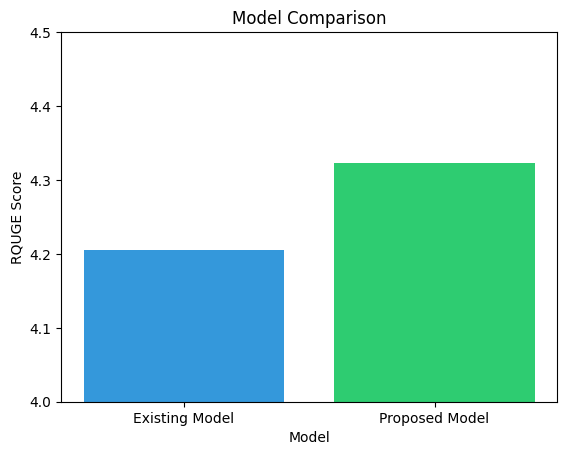

In [ ]:
existing_model = 4.204991698265076
our_model = 4.323174905776978

# Create lists for bar labels and values
models = ['Existing Model', 'Proposed Model']
rquge_scores = [existing_model, our_model]

# Plotting a bar graph
colors = ['#3498db', '#2ecc71']
plt.bar(models, rquge_scores, color=colors)

plt.xlabel('Model')
plt.ylabel('RQUGE Score')
plt.ylim(4, 4.5)
plt.title('Model Comparison')
plt.show()

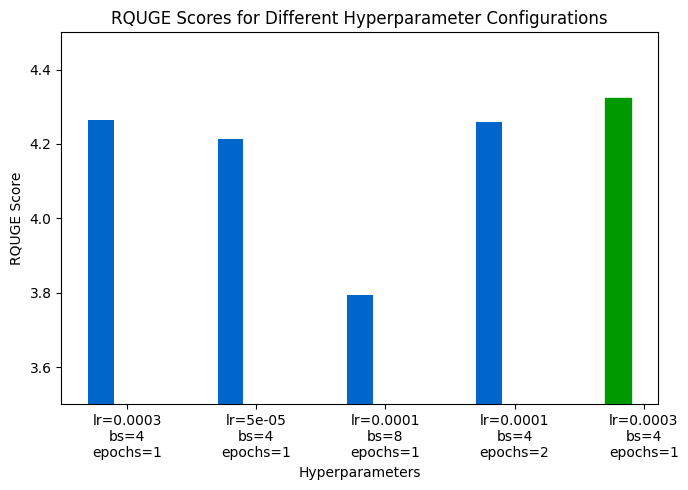

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Values
lr_values = [3e-4, 5e-5, 1e-4, 1e-4, 3e-4]
batch_size_values = [4, 4, 8, 4, 4]
max_epochs_values = [1, 1, 1, 2, 1]
rquge_values = [4.26549787521362, 4.214480185508728, 3.7941314339637757, 4.259808576107025, 4.323174905776978]

# Find the index of the highest RQUGE score
max_rquge_index = np.argmax(rquge_values)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))
bar_width = 0.2
bar_positions = range(len(lr_values))
plt.ylim(3.5, 4.5)

# Plot all bars
bars = ax.bar([pos - bar_width for pos in bar_positions], rquge_values, width=bar_width, label='RQUGE', color='#0066CC')

# Highlight the bar with the highest RQUGE score
bars[max_rquge_index].set_color('#009900')

ax.set_xticks(bar_positions)
ax.set_xticklabels([f'lr={lr}\nbs={bs}\nepochs={epochs}' for lr, bs, epochs in zip(lr_values, batch_size_values, max_epochs_values)])
ax.set_xlabel('Hyperparameters')
ax.set_ylabel('RQUGE Score')
ax.set_title('RQUGE Scores for Different Hyperparameter Configurations')

plt.tight_layout()
plt.show()